In [66]:
# Run this cell before continuing.
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)

# Examining Correlations between Month of the Year and Crime Rates

## Introduction
---

Our dataset contains crime data for 2022 in Vancouver. For each entry, the type of crime (break and enter, theft, etc…), the month, day, hour, and minute of when the crime occurred, and the address, neighbourhood and coordinates where it occurred are registered. 

The question we are trying to answer is whether crime occurs more often at certain times of the year than others. Our variable is the month of the year. Our eleven categories are the eleven types of crime defined in the database.

Our location parameter is the mode. In this particular question, finding the month when the most crime takes place makes more sense than finding the mean or median month when crimes take place—looking at available data from the Canadian government, the distribution of crime clusters around the month where it occurs the most. The mode would be more representative of the actual month of the year since, unlike the mean and median,  it is not skewed by outliers. Our scale parameter is the standard deviation to calculate the standard error for the data. Later in the project, the interquartile range can also be used to calculate the confidence interval and what percentage of crime occurs within a specific period. 

Our null hypothesis is that crime is distributed evenly across the year. Our alternative hypothesis is that crime will occur the most in the summer months of July to August. Heat has frequently been associated with higher rates of criminality, according to many scientific papers and these are the hottest months in Vancouver.

We will not only find the distribution of months for all the entries in the database. We will also find the distributions for different types of crime and in different neighbourhoods to see if any trends are universal, regardless of the type of crime or neighbourhood.

## Preliminary Results
---

In [64]:
# setwd("/home/jovyan/work/project")

In [29]:
crime_data <- read_csv("data/crimedata_csv_AllNeighbourhoods_2022.csv")
head(crime_data)

Rows: 34281 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2022,1,3,16,19,10XX ALBERNI ST,West End,491036.1,5459146
Break and Enter Commercial,2022,6,17,5,16,10XX ALBERNI ST,West End,491067.3,5459115
Break and Enter Commercial,2022,3,15,5,14,10XX ALBERNI ST,West End,491102.2,5459092
Break and Enter Commercial,2022,3,19,6,42,10XX ALBERNI ST,West End,491102.2,5459092
Break and Enter Commercial,2022,2,23,23,0,10XX BALFOUR AVE,Shaughnessy,490699.8,5455444
Break and Enter Commercial,2022,2,25,10,15,10XX BALFOUR AVE,Shaughnessy,490699.8,5455444


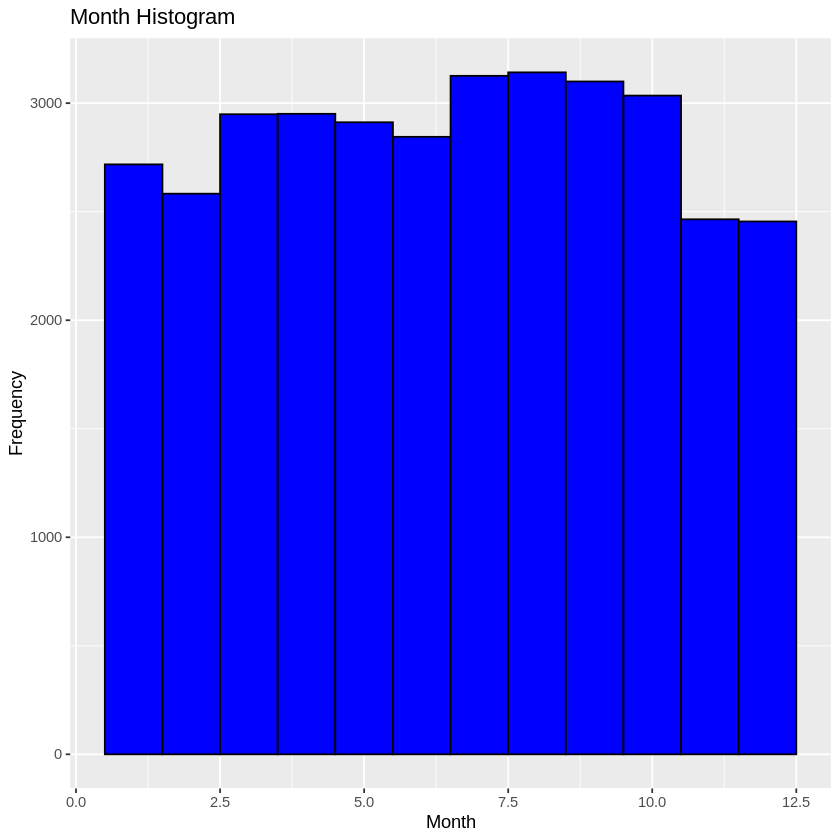

In [65]:
crime_month_category <- crime_data[c("MONTH", "TYPE")]
crime_month_dist <- ggplot(crime_month_category, aes(x = MONTH)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  labs(title = "Month Histogram", x = "Month", y = "Frequency")
crime_month_dist

explaination of the population month histogram:

In [ ]:
get_mode <- function(v) {
   unique_values <- unique(v)
   unique_values[which.max(tabulate(match(v, unique_values)))]
}

get_mode(crime_month_category$MONTH)

In [48]:
categories <- unique(crime_month_category$TYPE)
length(categories)

[1] 11

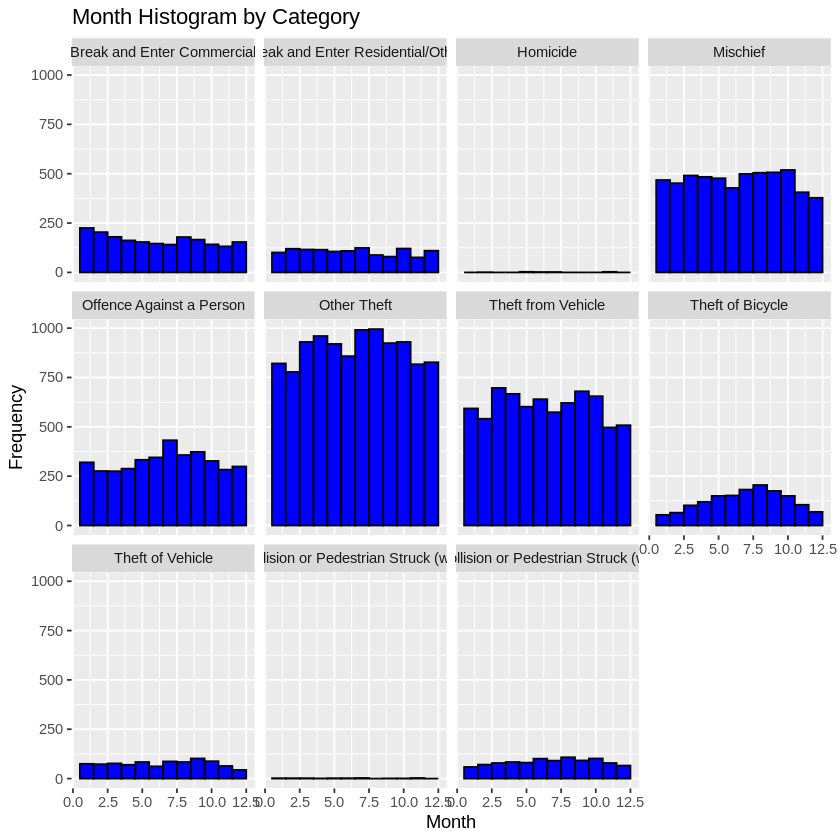

In [62]:
ggplot(crime_month_category, aes(x = MONTH)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  facet_wrap(~ TYPE, ncol = 4) +
  labs(title = "Month Histogram by Category", x = "Month", y = "Frequency")



In [63]:
modes <- sapply(split(crime_month_category$MONTH, crime_month_category$TYPE), get_mode)
data.frame(category = names(modes), mode = as.numeric(modes))


category,mode
<chr>,<dbl>
Break and Enter Commercial,1
Break and Enter Residential/Other,7
Homicide,5
Mischief,10
Offence Against a Person,7
Other Theft,8
Theft from Vehicle,3
Theft of Bicycle,8
Theft of Vehicle,9


explaination of each category mode:

## Methods: Plan

---
* What do you expect to find?

We expect to find our alternative hypothesis to be true. Crime will be the most common in the summer months, and this trend will stay consistent for different types of crimes and for different neighbourhoods within Vancouver. 
 
* What impact could such findings have?

Understanding the relationship between temperature and crime can tell law enforcement agencies when and where to allocate police resources efficiently. It may additionally cause more centred and efficient policing techniques, reducing crime rates during peak periods.

* What future questions could this lead to?

Beyond temperature, what different elements (i.e. vacations, festivals, or tourism) could influence crime rates? Our research can be continued with those variables to verify if the hot temperature is the main reason for rising crime rates in summer.

* How can urban planning and environmental layout mitigate the impact of heat on crime?

Research may lead to progressive architectural and infrastructure solutions to lower crime during severe weather situations.

### References
Moreau, Greg. “Police-Reported Crime Statistics in Canada, 2020.” Statcan, Statistics, Canada, 27 July 2021,  www150.statcan.gc.ca/n1/pub/85-002-x/2021001/article/00013-eng.htm . Accessed 4 Nov. 2023.
Field, Simon. “THE EFFECT OF TEMPERATURE ON CRIME.” The British Journal of Criminology, vol. 32, no. 3, 1992, pp. 340–51. JSTOR, 
http://www.jstor.org/stable/23637533. Accessed 4 Nov. 2023.
Corcoran, Jonathan, and Renee Zahnow. “Weather and crime: A systematic review of the empirical literature.” Crime Science, vol. 11, no. 1, 2022, 
https://doi.org/10.1186/s40163-022-00179-8. Accessed 4 Nov. 2023.